### Importing Libaries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets  # New import
from shapely.geometry import Point
import seaborn as sns

### Loading the dataset

In [6]:
file_path = "ibtracs.last3years.list.v04r01.csv"
df = pd.read_csv(file_path, encoding="latin1", low_memory=False)

### Data inspection and summary

In [7]:
df.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,2022008S13148,2022,1,SP,EA,TIFFANY,2022-01-08 00:00:00,MX,-12.6,147.7,...,45,,,,,,,,6,160
2,2022008S13148,2022,1,SP,EA,TIFFANY,2022-01-08 03:00:00,MX,-12.9,147.8,...,,,,,,,,,5,160
3,2022008S13148,2022,1,SP,EA,TIFFANY,2022-01-08 06:00:00,MX,-13.1,147.9,...,45,,,,,,,,4,160
4,2022008S13148,2022,1,SP,EA,TIFFANY,2022-01-08 09:00:00,MX,-13.2,147.9,...,,,,,,,,,2,165


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17925 entries, 0 to 17924
Columns: 174 entries, SID to STORM_DIR
dtypes: int64(1), object(173)
memory usage: 23.8+ MB


In [9]:
df.describe()

,USA_SSHS
count,17925.000000
mean,-0.843570
std,2.265902
min,-5.000000
25%,-3.000000
50%,0.000000
75%,0.000000
max,5.000000


### Checking for missing values

In [10]:
df.isnull().sum()

SID                 0
SEASON              0
NUMBER              0
BASIN            3605
SUBBASIN         2808
                 ... 
USA_SEARAD_SE       0
USA_SEARAD_SW       0
USA_SEARAD_NW       0
STORM_SPEED         0
STORM_DIR           0
Length: 174, dtype: int64

### Converting LAT and LON to numeric values, ignoring errors

In [11]:
df['LAT'] = pd.to_numeric(df['LAT'], errors='coerce')
df['LON'] = pd.to_numeric(df['LON'], errors='coerce')

### Remove rows with missing coordinates

In [12]:
df = df.dropna(subset=['LAT', 'LON'])

### Loading a world map from the new geodatasets package

In [13]:
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

### Create a GeoDataFrame for storm tracks

In [14]:
geometry = [Point(xy) for xy in zip(df['LON'], df['LAT'])]
storm_gdf = gpd.GeoDataFrame(df, geometry=geometry)

### Plot 1: Tropical Cyclone Tracks

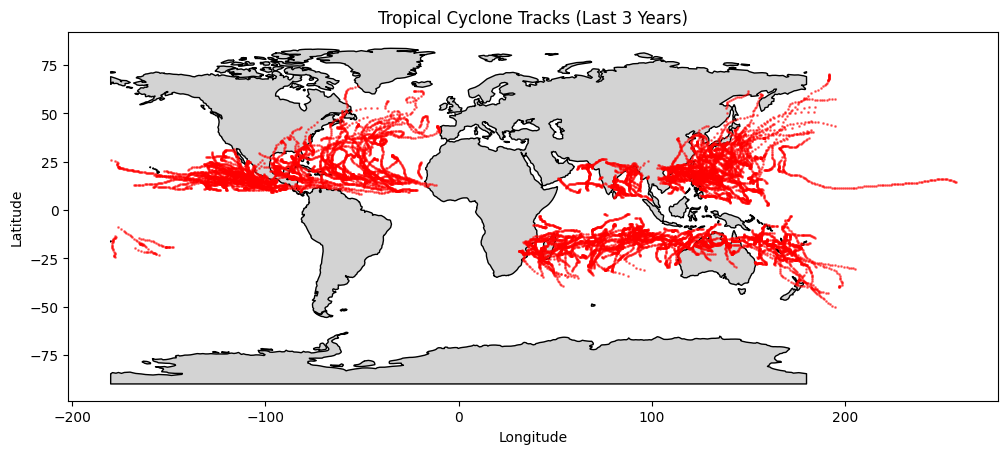

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color='lightgray', edgecolor='black')
storm_gdf.plot(ax=ax, markersize=1, color='red', alpha=0.5)
ax.set_title("Tropical Cyclone Tracks (Last 3 Years)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

### Plot 2: Storm Frequency by Year

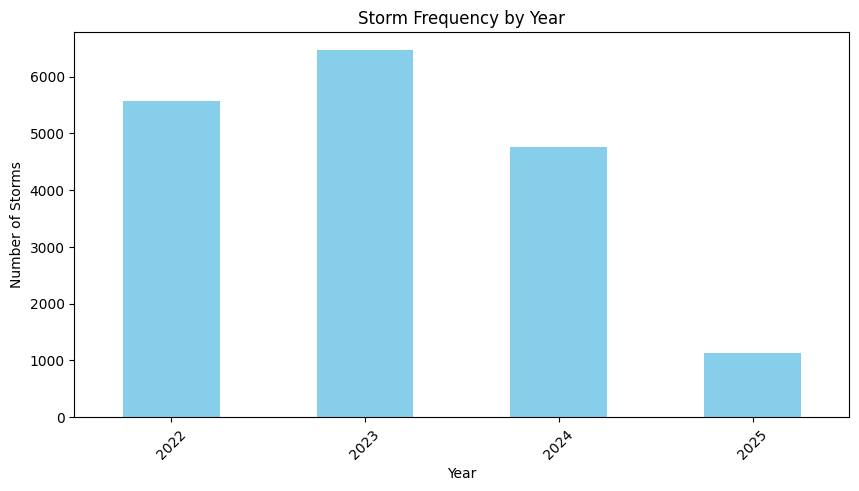

In [16]:
df['SEASON'] = pd.to_numeric(df['SEASON'], errors='coerce')
storm_counts = df.groupby('SEASON').size()
plt.figure(figsize=(10, 5))
storm_counts.plot(kind='bar', color='skyblue')
plt.title("Storm Frequency by Year")
plt.xlabel("Year")
plt.ylabel("Number of Storms")
plt.xticks(rotation=45)
plt.show()

### Plot 3: Storm Intensity Over Time (Wind Speed Trend)

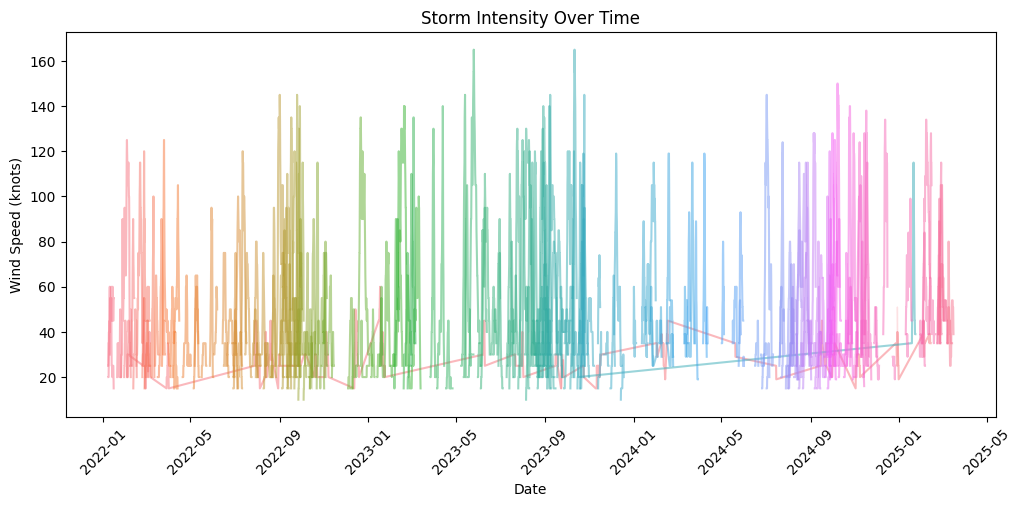

In [17]:
if 'USA_WIND' in df.columns:
    df['USA_WIND'] = pd.to_numeric(df['USA_WIND'], errors='coerce')
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'], errors='coerce')
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=df['ISO_TIME'], y=df['USA_WIND'], hue=df['NAME'], legend=False, alpha=0.5)
    plt.title("Storm Intensity Over Time")
    plt.xlabel("Date")
    plt.ylabel("Wind Speed (knots)")
    plt.xticks(rotation=45)
    plt.show()

### Plot 4: Storm Tracks by Basin

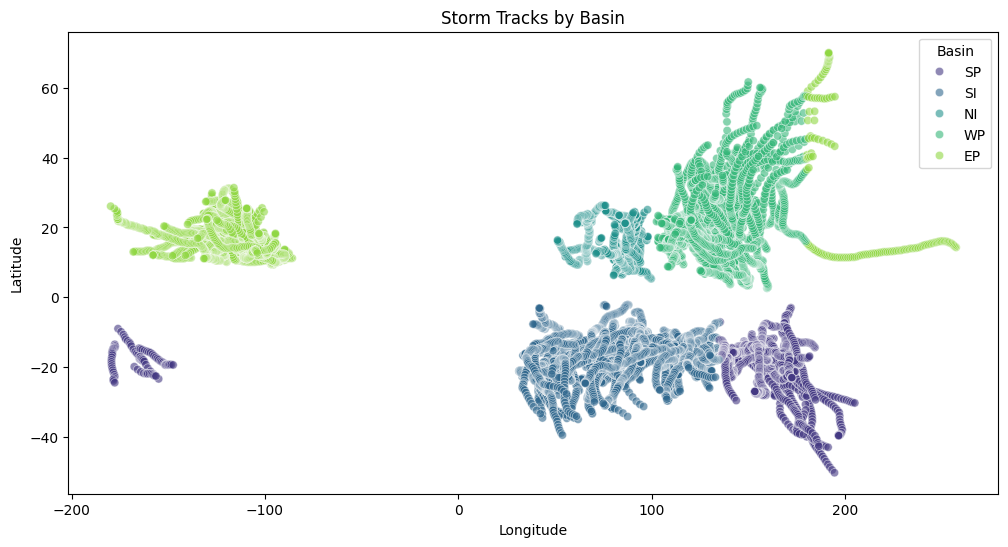

In [18]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['LON'], y=df['LAT'], hue=df['BASIN'], palette='viridis', alpha=0.6)
plt.title("Storm Tracks by Basin")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Basin")
plt.show()

### Plot 5: Storm Distribution by Basin (Pie Chart)

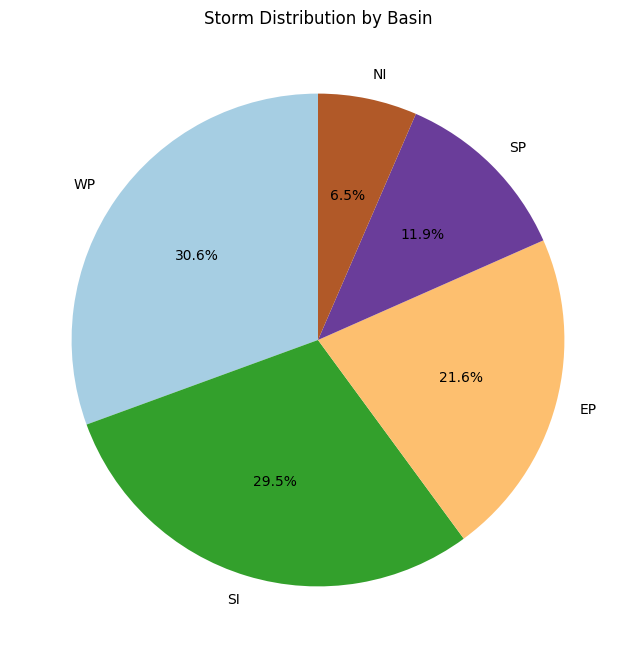

In [19]:
if 'BASIN' in df.columns:
    basin_counts = df['BASIN'].value_counts()
    plt.figure(figsize=(8, 8))
    basin_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Paired')
    plt.title("Storm Distribution by Basin")
    plt.ylabel("")
    plt.show()

### Plot 6: Scatter Plot of Wind Speed vs Pressure 

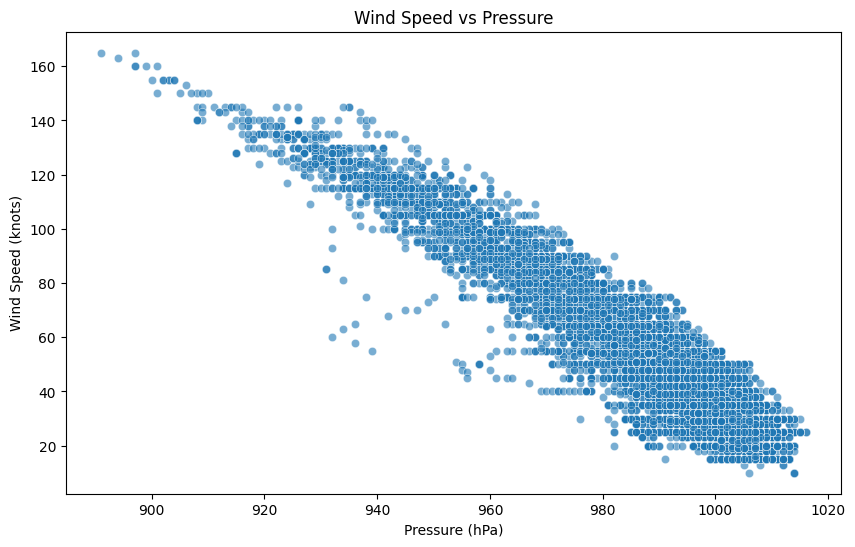

In [20]:
if 'USA_WIND' in df.columns and 'USA_PRES' in df.columns:
    df['USA_PRES'] = pd.to_numeric(df['USA_PRES'], errors='coerce')
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['USA_PRES'], y=df['USA_WIND'], alpha=0.6)
    plt.title("Wind Speed vs Pressure")
    plt.xlabel("Pressure (hPa)")
    plt.ylabel("Wind Speed (knots)")
    plt.show()

### Plot 7: Correlation Matrix Heatmap

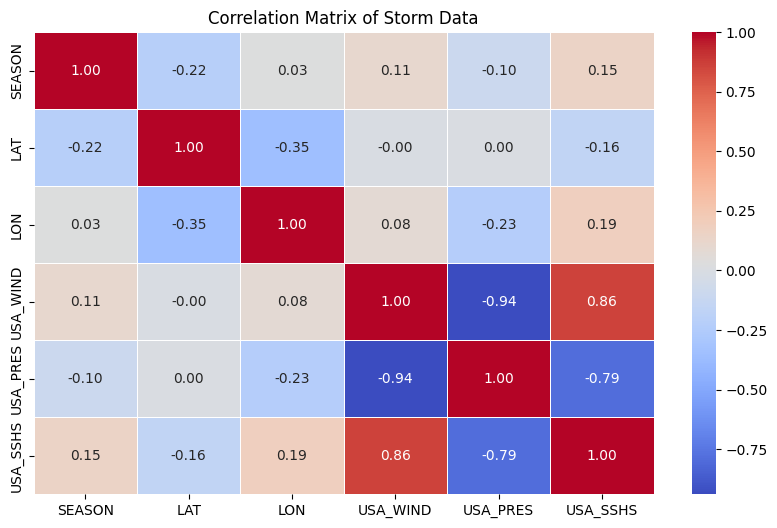

In [23]:
numeric_df = df.select_dtypes(include=[np.number]).dropna()
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Storm Data")
plt.show()

### Plot 8: Histogram of Wind Speeds

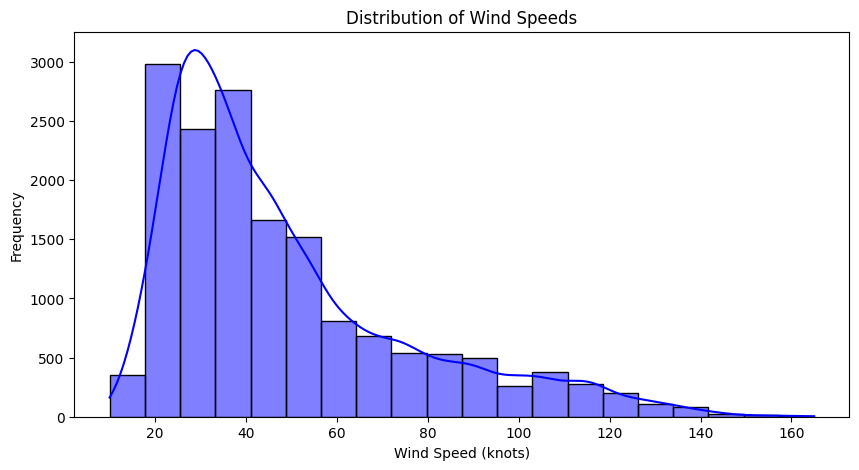

In [21]:
if 'USA_WIND' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df['USA_WIND'].dropna(), bins=20, kde=True, color='blue')
    plt.title("Distribution of Wind Speeds")
    plt.xlabel("Wind Speed (knots)")
    plt.ylabel("Frequency")
    plt.show()

### Plot 9: Box Plot of Storm Intensity

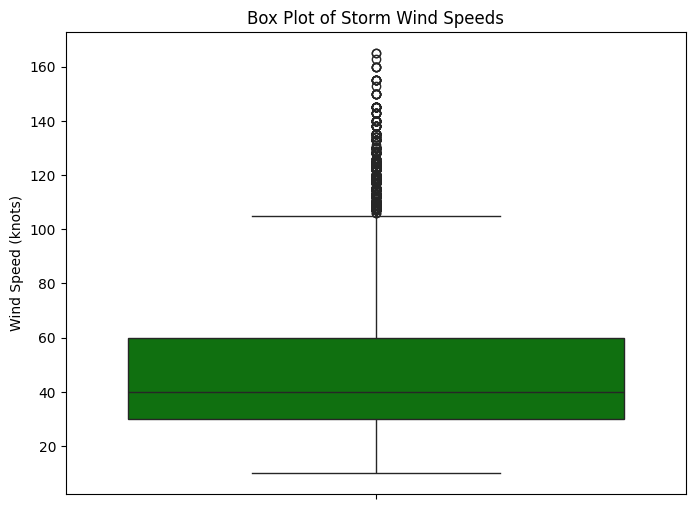

In [22]:
if 'USA_WIND' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df['USA_WIND'], color='green')
    plt.title("Box Plot of Storm Wind Speeds")
    plt.ylabel("Wind Speed (knots)")
    plt.show()

### Data Analysis & Insights

In [23]:
print("\n### Data Analysis & Insights ###\n")
if 'USA_WIND' in df.columns:
    print(f"Average Wind Speed: {df['USA_WIND'].mean():.2f} knots")
    print(f"Maximum Wind Speed: {df['USA_WIND'].max()} knots")
    print(f"Minimum Wind Speed: {df['USA_WIND'].min()} knots")
if 'USA_PRES' in df.columns:
    print(f"Average Pressure: {df['USA_PRES'].mean():.2f} hPa")
    print(f"Lowest Pressure Recorded: {df['USA_PRES'].min()} hPa")
if 'BASIN' in df.columns:
    most_common_basin = df['BASIN'].mode()[0]
    print(f"Most Common Storm Basin: {most_common_basin}")
if 'SEASON' in df.columns:
    most_active_year = df['SEASON'].value_counts().idxmax()
    print(f"Year with Most Storms: {most_active_year}")


### Data Analysis & Insights ###

Average Wind Speed: 48.61 knots
Maximum Wind Speed: 165.0 knots
Minimum Wind Speed: 10.0 knots
Average Pressure: 990.58 hPa
Lowest Pressure Recorded: 891.0 hPa
Most Common Storm Basin: WP
Year with Most Storms: 2023
